<a href="https://colab.research.google.com/github/Abdelrahman26/FarmTopia-CV-Internship/blob/main/FarmTopia-CV-Internship/Anwar/HDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original images


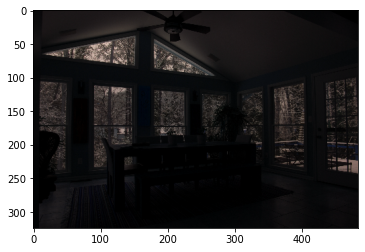

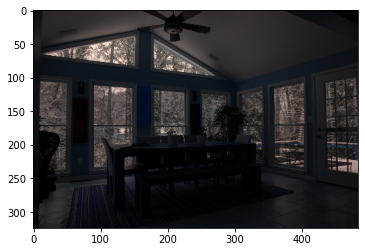

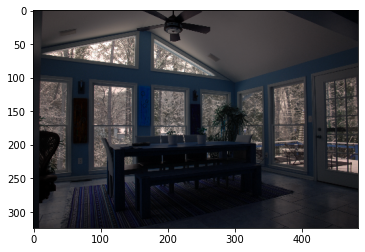

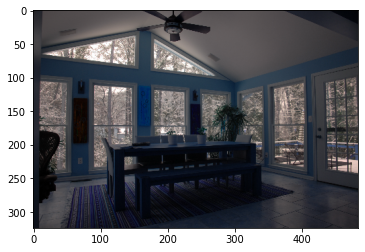

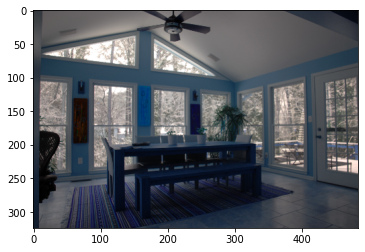

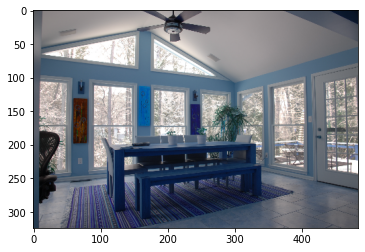

HDR image
(324, 484, 3)


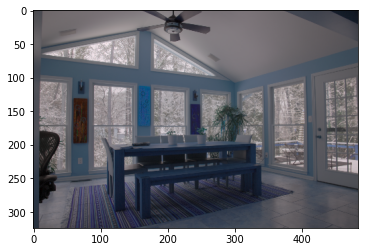

In [15]:
'''
from
https://github.com/vivianhylee/high-dynamic-range-image
'''
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

def linearWeight(pixel_value):
    """ Linear weighting function based on pixel intensity that reduces the
    weight of pixel values that are near saturation.
    Parameters
    ----------
    pixel_value : np.uint8
        A pixel intensity value from 0 to 255
    Returns
    -------
    weight : np.float64
        The weight corresponding to the input pixel intensity
    """
    z_min, z_max = 0., 255.
    if pixel_value <= (z_min + z_max) / 2:
        return pixel_value - z_min
    return z_max - pixel_value


def sampleIntensities(images):
    """Randomly sample pixel intensities from the exposure stack.
    Parameters
    ----------
    images : list<numpy.ndarray>
        A list containing a stack of single-channel (i.e., grayscale)
        layers of an HDR exposure stack
    Returns
    -------
    intensity_values : numpy.array, dtype=np.uint8
        An array containing a uniformly sampled intensity value from each
        exposure layer (shape = num_intensities x num_images)
    """
    z_min, z_max = 0, 255
    num_intensities = z_max - z_min + 1
    num_images = len(images)
    intensity_values = np.zeros((num_intensities, num_images), dtype=np.uint8)

    # Find the middle image to use as the source for pixel intensity locations
    mid_img = images[num_images // 2]

    for i in range(z_min, z_max + 1):
        rows, cols = np.where(mid_img == i)
        if len(rows) != 0:
            idx = random.randrange(len(rows))
            for j in range(num_images):
                intensity_values[i, j] = images[j][rows[idx], cols[idx]]
    return intensity_values


def computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, weighting_function):
    """Find the camera response curve for a single color channel
    Parameters
    ----------
    intensity_samples : numpy.ndarray
        Stack of single channel input values (num_samples x num_images)
    log_exposures : numpy.ndarray
        Log exposure times (size == num_images)
    smoothing_lambda : float
        A constant value used to correct for scale differences between
        data and smoothing terms in the constraint matrix -- source
        paper suggests a value of 100.
    weighting_function : callable
        Function that computes a weight from a pixel intensity
    Returns
    -------
    numpy.ndarray, dtype=np.float64
        Return a vector g(z) where the element at index i is the log exposure
        of a pixel with intensity value z = i (e.g., g[0] is the log exposure
        of z=0, g[1] is the log exposure of z=1, etc.)
    """
    z_min, z_max = 0, 255
    intensity_range = 255  # difference between min and max possible pixel value for uint8
    num_samples = intensity_samples.shape[0]
    num_images = len(log_exposures)

    # NxP + [(Zmax-1) - (Zmin + 1)] + 1 constraints; N + 256 columns
    mat_A = np.zeros((num_images * num_samples + intensity_range, num_samples + intensity_range + 1), dtype=np.float64)
    mat_b = np.zeros((mat_A.shape[0], 1), dtype=np.float64)

    # 1. Add data-fitting constraints:
    k = 0
    for i in range(num_samples):
        for j in range(num_images):
            z_ij = intensity_samples[i, j]
            w_ij = weighting_function(z_ij)
            mat_A[k, z_ij] = w_ij
            mat_A[k, (intensity_range + 1) + i] = -w_ij
            mat_b[k, 0] = w_ij * log_exposures[j]
            k += 1

    # 2. Add smoothing constraints:
    for z_k in range(z_min + 1, z_max):
        w_k = weighting_function(z_k)
        mat_A[k, z_k - 1] = w_k * smoothing_lambda
        mat_A[k, z_k    ] = -2 * w_k * smoothing_lambda
        mat_A[k, z_k + 1] = w_k * smoothing_lambda
        k += 1

    # 3. Add color curve centering constraint:
    mat_A[k, (z_max - z_min) // 2] = 1

    inv_A = np.linalg.pinv(mat_A)
    x = np.dot(inv_A, mat_b)

    g = x[0: intensity_range + 1]
    return g[:, 0]


def computeRadianceMap(images, log_exposure_times, response_curve, weighting_function):
    """Calculate a radiance map for each pixel from the response curve.
    Parameters
    ----------
    images : list
        Collection containing a single color layer (i.e., grayscale)
        from each image in the exposure stack. (size == num_images)
    log_exposure_times : numpy.ndarray
        Array containing the log exposure times for each image in the
        exposure stack (size == num_images)
    response_curve : numpy.ndarray
        Least-squares fitted log exposure of each pixel value z
    weighting_function : callable
        Function that computes the weights
    Returns
    -------
    numpy.ndarray(dtype=np.float64)
        The image radiance map (in log space)
    """
    img_shape = images[0].shape
    img_rad_map = np.zeros(img_shape, dtype=np.float64)

    num_images = len(images)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            g = np.array([response_curve[images[k][i, j]] for k in range(num_images)])
            w = np.array([weighting_function(images[k][i, j]) for k in range(num_images)])
            SumW = np.sum(w)
            if SumW > 0:
                img_rad_map[i, j] = np.sum(w * (g - log_exposure_times) / SumW)
            else:
                img_rad_map[i, j] = g[num_images // 2] - log_exposure_times[num_images // 2]
    return img_rad_map


def globalToneMapping(image, gamma):
    """Global tone mapping using gamma correction
    ----------
    images : <numpy.ndarray>
        Image needed to be corrected
    gamma : floating number
        The number for gamma correction. Higher value for brighter result; lower for darker
    Returns
    -------
    numpy.ndarray
        The resulting image after gamma correction
    """
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected


def intensityAdjustment(image, template):
    """Tune image intensity based on template
        ----------
        images : <numpy.ndarray>
            image needed to be adjusted
        template : <numpy.ndarray>
            Typically we use the middle image from image stack. We want to match the image
            intensity for each channel to template's
        Returns
        -------
        numpy.ndarray
            The resulting image after intensity adjustment
        """
    m, n, channel = image.shape
    output = np.zeros((m, n, channel))
    for ch in range(channel):
        image_avg, template_avg = np.average(image[:, :, ch]), np.average(template[:, :, ch])
        output[..., ch] = image[..., ch] * (template_avg / image_avg)

    return output


def computeHDR(images, log_exposure_times, smoothing_lambda=100., gamma=0.6):
    """Computational pipeline to produce the HDR images
    ----------
    images : list<numpy.ndarray>
        A list containing an exposure stack of images
    log_exposure_times : numpy.ndarray
        The log exposure times for each image in the exposure stack
    smoothing_lambda : np.int (Optional)
        A constant value to correct for scale differences between
        data and smoothing terms in the constraint matrix -- source
        paper suggests a value of 100.
    Returns
    -------
    numpy.ndarray
        The resulting HDR with intensities scaled to fit uint8 range
    """

    num_channels = images[0].shape[2]
    hdr_image = np.zeros(images[0].shape, dtype=np.float64)

    for channel in range(num_channels):
        # Collect the current layer of each input image from the exposure stack
        layer_stack = [img[:, :, channel] for img in images]

        # Sample image intensities
        intensity_samples = sampleIntensities(layer_stack)

        # Compute Response Curve
        response_curve = computeResponseCurve(intensity_samples, log_exposure_times, smoothing_lambda, linearWeight)

        # Build radiance map
        img_rad_map = computeRadianceMap(layer_stack, log_exposure_times, response_curve, linearWeight)

        # Normalize hdr layer to (0, 255)
        dst = np.zeros(shape=(images[0].shape[0],images[0].shape[1]))
        hdr_image[..., channel] = cv2.normalize(src = img_rad_map,dst = dst ,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Global tone mapping
    image_mapped = globalToneMapping(hdr_image, gamma)

    # Adjust image intensity based on the middle image from image stack
    template = images[len(images)//2]
    image_tuned = intensityAdjustment(image_mapped, template)

    # Output image
    dst = np.zeros(shape=(images[0].shape[0],images[0].shape[1]))
    output = cv2.normalize(image_tuned,dst = dst, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return output.astype(np.uint8)

def readImages(imageString, plot = True):
	'''
	 input: list of images names
	 output: list of rgb images
	'''
	images = []
	# Get images from arguments.
	for i in range(0, len(imageString)):
		img = cv2.imread(imageString[i],cv2.COLOR_BGR2RGB)
		images.append(img)
		if plot == True:
			plt.imshow(img)
		plt.show()

	return images
print('Original images')
imgs = readImages(['sample-00.png','sample-01.png','sample-02.png','sample-03.png','sample-04.png','sample-05.png'], plot = True)
log_exposure_times = [1/160 , 1/125 , 1/80 , 1/60 , 1/40, 1/15]
#print(np.array(imgs[0]).shape)
HDR = computeHDR(imgs , log_exposure_times)
print('HDR image')
print(HDR.shape)
plt.imshow(HDR)
plt.show()
